## Анализ и моделирование случайных величин на основе эмпирических данных

In [27]:
import numpy as np
from matplotlib import pyplot as plt
import math
from math import comb
import seaborn as sns

### 1. Импорт данных

#### Загрузка всех файлов и обработка потенциальных ошибок

In [28]:
file_names = ["set_1.csv", "set_2.csv", "set_3.csv"]
datasets: list[np.ndarray] = []

for file_name in file_names:
    try:
        with open(file_name, "r") as file:
            line = file.readline()
            file_data: np.ndarray = np.array([float(x) for x in line.strip().split(",")])

        datasets.append(file_data)
        print(
            f"Файл {file_name} загружен. Прочитано {len(file_data)} элементов."
        )
    except FileNotFoundError:
        # Файл не найден
        print(f"Ошибка: файл {file_name} не найден.")
    except ValueError:
        # Некорректные данные
        print(f"Ошибка: файл {file_name} содержит некорректные данные.")
    except Exception as e:
        # Другие ошибки
        print(f"Ошибка при обработке файла {file_name}: {e}")

if not datasets:
    print("Файлы не были загружены.")
else:
    print("Данные успешно загружены.")

Файл set_1.csv загружен. Прочитано 100000 элементов.
Файл set_2.csv загружен. Прочитано 10000 элементов.
Файл set_3.csv загружен. Прочитано 100000 элементов.
Данные успешно загружены.


### 2. Анализ данных

#### Функции для расчета математического ожидания и дисперсии для каждого набора данных

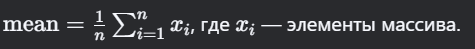

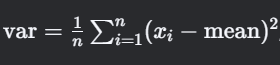

In [29]:
def calculate_mean(data) -> float:
    if len(data) == 0:
        raise ValueError("Массив данных пуст.")
    mean = sum(data) / len(data)
    return mean

def calculate_variance(data) -> float:
    if len(data) == 0:
        raise ValueError("Массив данных пуст.")
    mean = calculate_mean(data)
    variance = sum([(x - mean) ** 2 for x in data]) / len(data)
    return variance

#### Вычисление математического ожидания и дисперсии для каждого набора данных

In [30]:
for i, dataset in enumerate(datasets, start=1):
    try:
        mean = calculate_mean(dataset)
        variance = calculate_variance(dataset)
        print(f"Набор данных {i}:")
        print(f"M[x]: {mean}")
        print(f"D[x]: {variance}")
        print()
    except ValueError as e:
        print(f"Ошибка при расчете для набора данных {i}: {e}")

Набор данных 1:
M[x]: 3.44078
D[x]: 10.048192991590511

Набор данных 2:
M[x]: 16.243283213799984
D[x]: 10927.40462765338

Набор данных 3:
M[x]: 0.12448845074999802
D[x]: 0.025645435018138915



### 3. Обнаружение и удаления выбросов

#### Правило Стерджеса для определения оптимального количества интервалов, на которые разбивается диапазон изменения случайной величины

### Количество интервалов n определяется как:
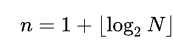
### Часто встречается записанным через десятичный логарифм
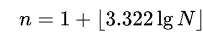
### Где N - общее число наблюдений величины.

In [31]:
def calculate_sturges(data: np.ndarray) -> int:
    n = len(data)
    if n == 0:
        return 1
    
    num_int = 1 + math.floor(np.log2(n))
    return num_int

#### Функция для построения нормированных гистограмм

In [32]:
def draw_gistograms(datasets):

    plt.style.use("seaborn-v0_8-darkgrid")

    colors = sns.color_palette("husl", len(datasets))

    for i, data in enumerate(datasets, start=1):
        bins = calculate_sturges(data)
        mean = calculate_mean(data)
        variance = calculate_variance(data)

        plt.figure(figsize=(8, 5)) # Размер
        plt.hist(
            data,
            bins=bins, # Количество столбцов
            density=True, # Нормализация гистограммы (площадь под гистограммой = 1)
            alpha=0.8, 
            color=colors[i % len(colors)], 
            edgecolor="black", # Границы
            linewidth=1.5
        )
        plt.title(f"Гистограмма для набора данных {i}", fontsize=14, fontweight="bold")
        plt.xlabel("Значение", fontsize=12)
        plt.ylabel("Плотность", fontsize=12)
        plt.grid(axis="y", linestyle="--", alpha=0.6) # Горизонтальная сетка
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.text(0.0, -0.2, f'M[x]: {mean:.2f}\nD[x]: {variance:.2f}',
                  transform=plt.gca().transAxes, 
                  fontsize=10, 
                  bbox=dict(facecolor='white', edgecolor='black', alpha=0.9, boxstyle="round,pad=0.4" ) # Рамка
                )
        plt.show()

### Сравнение методов удаления выбросов

### Метод Z-оценки

### Вычисляет стандартизированное отклонение каждого значения от среднего. Если Z-оценка выходит за пределы определённого порога (например, ∣Z∣>3), значение считается выбросом.
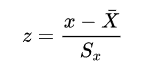

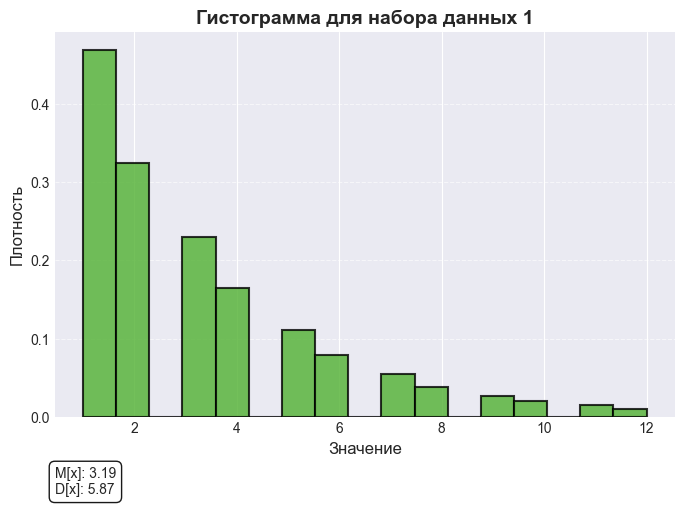

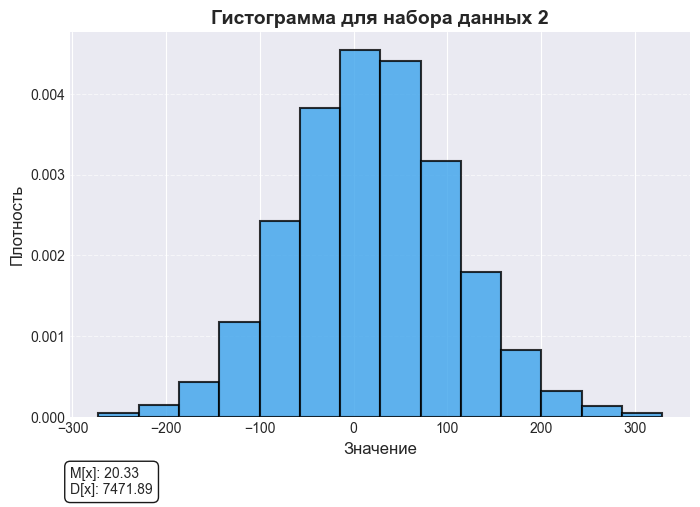

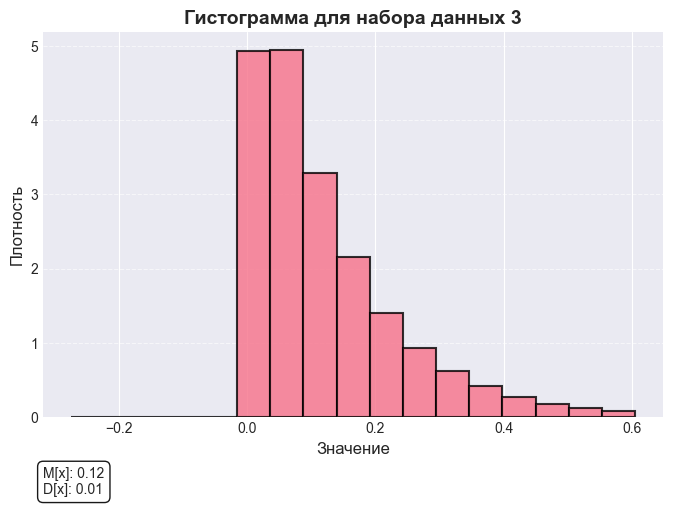

In [33]:
def clean_outliers_zscore(data: np.ndarray, threshold: float = 3):
    """
    Обнаруживает выбросы с помощью Z-оценки.
    :param data: Массив данных.
    :param threshold: Порог для Z-оценки (по умолчанию 3).
    :return: Очищенные данные.
    """
    mean = calculate_mean(data)
    variance = calculate_variance(data)
    std = np.sqrt(variance)
    clean_data = [x for x in data if abs((x - mean) / std) < threshold]

    return clean_data

clean_data = []
for i, dataset in enumerate(datasets):
    clean_data.append(clean_outliers_zscore(dataset))

draw_gistograms(clean_data)

### Метод IQR (Interquartile Range)

### Использует межквартильный размах (IQR) для определения выбросов. Выбросами считаются значения, выходящие за пределы: [Q1−1.5⋅IQR, Q3+1.5⋅IQR], где
### Q1 - первый квартиль (25-й процентиль),
### Q3 - третий квартиль (75-й процентиль)
### IQR = Q3 - Q1

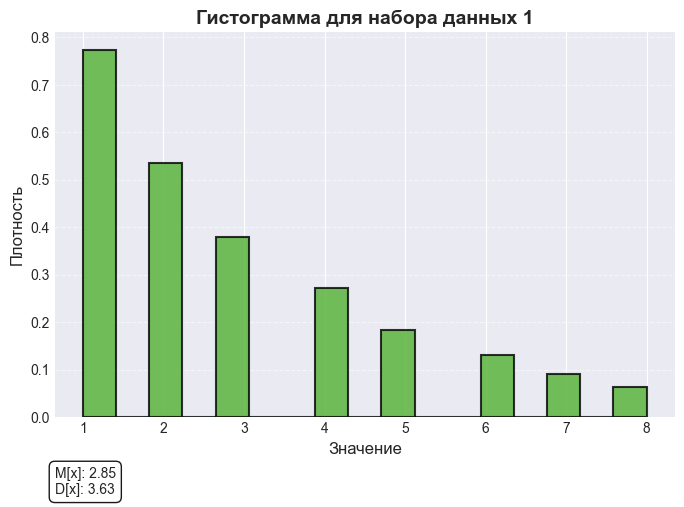

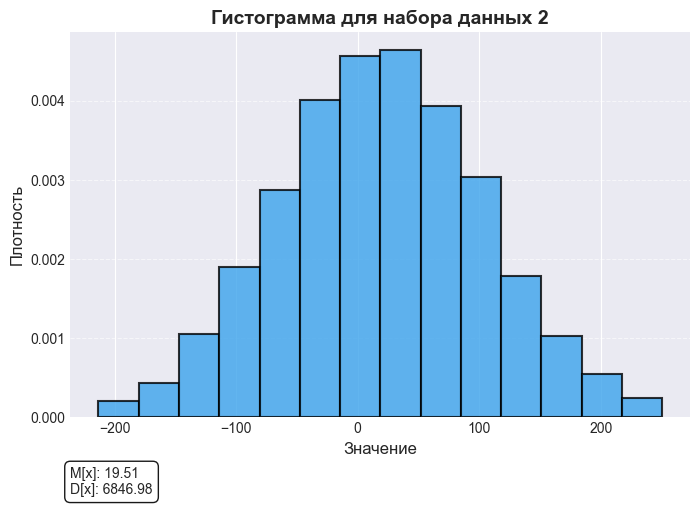

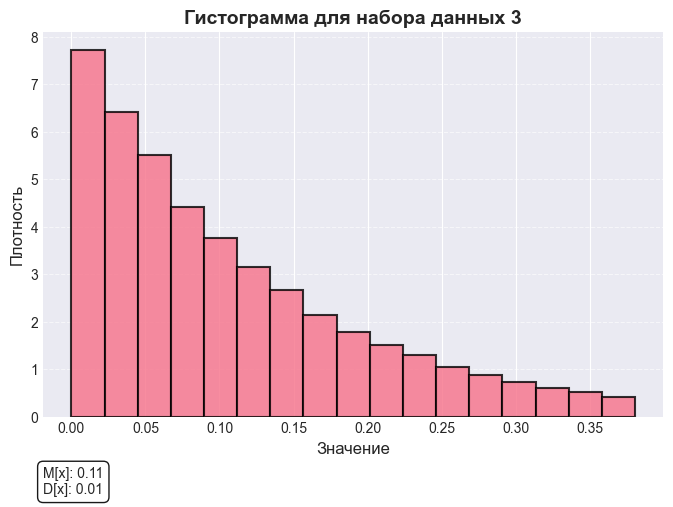

In [34]:
def clean_outliers_iqr(data: np.ndarray, k: float = 1.5):
    """
    Обнаруживает выбросы с помощью метода IQR.
    :param data: Массив данных.
    :param k: Множитель для IQR (по умолчанию 1.5).
    :return: Очищенные данные.
    """
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1 # Межквартильный размах
    lower_bound = q1 - k * iqr # Нижняя граница
    upper_bound = q3 + k * iqr # Верхняя граница

    clean_data = [x for x in data if lower_bound <= x <= upper_bound]

    return clean_data

clean_data = []
for i, dataset in enumerate(datasets):
    clean_data.append(clean_outliers_iqr(dataset))

draw_gistograms(clean_data)

### Тримминг (Обрезка по процентилям)

### Удаляет определённый процент наименьших и наибольших значений.

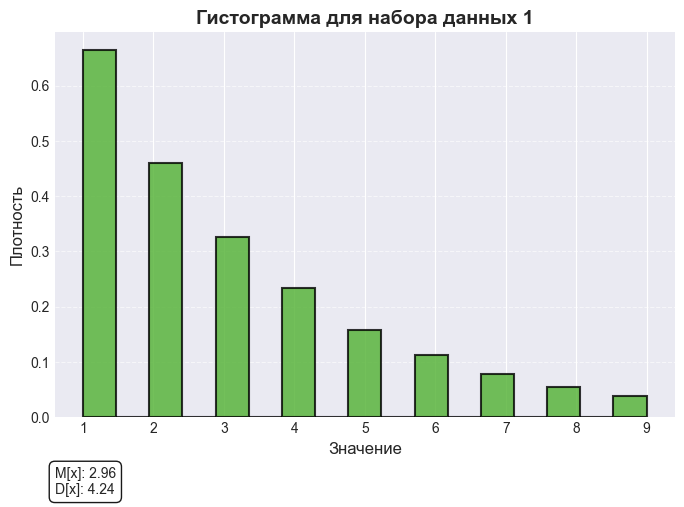

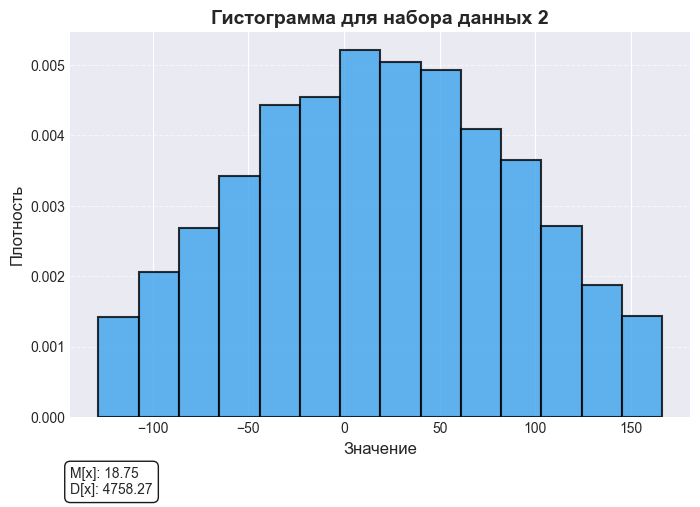

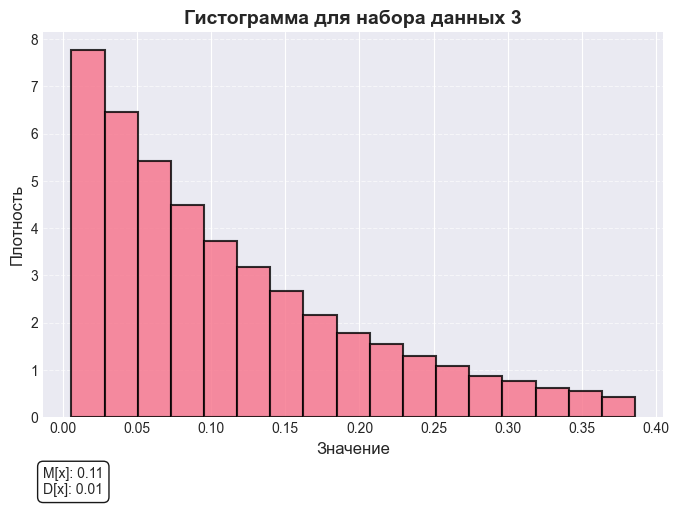

In [35]:
def clean_trim(data: np.ndarray, lower_percentile: float = 5, upper_percentile: float = 95):
    """
    Удаляет выбросы с помощью обрезки по процентилям.
    :param data: Массив данных.
    :param lower_percentile: Нижний процентиль (по умолчанию 5).
    :param upper_percentile: Верхний процентиль (по умолчанию 95).
    :return: Очищенные данные.
    """
    lower_bound = np.percentile(data, lower_percentile)
    upper_bound = np.percentile(data, upper_percentile)

    clean_data = [x for x in data if lower_bound <= x <= upper_bound]

    return clean_data

clean_data = []
for i, dataset in enumerate(datasets):
    clean_data.append(clean_trim(dataset))

draw_gistograms(clean_data)

### Винзоризация (Winsorization)

### Заменяет выбросы на ближайшие значения, не являющиеся выбросами. Например, все значения выше 95-го процентиля заменяются на значение 95-го процентиля.

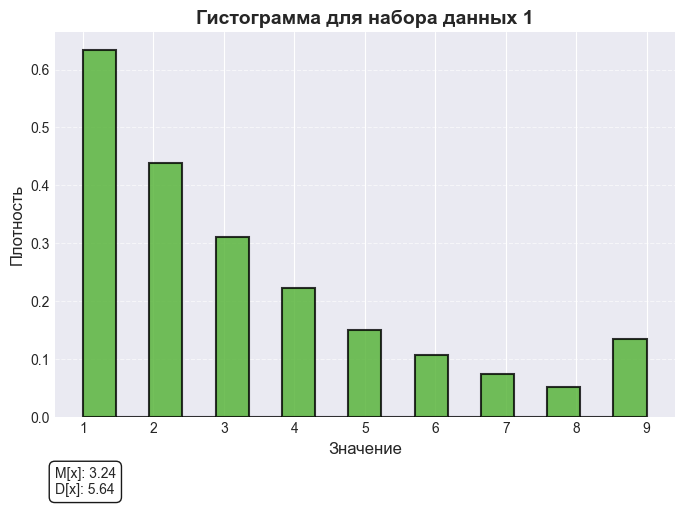

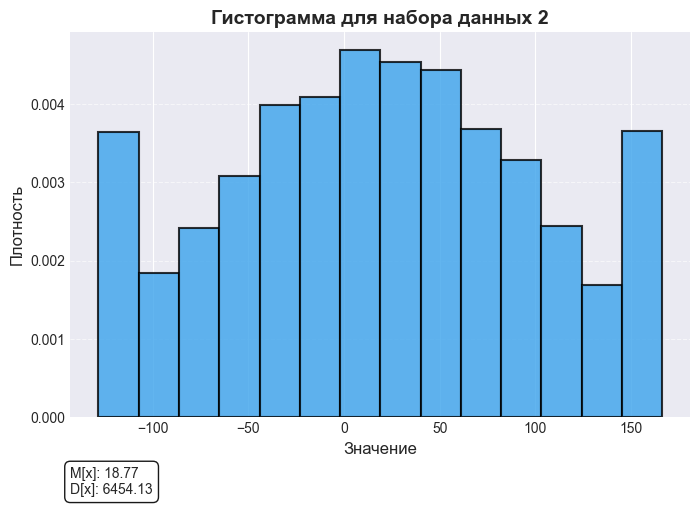

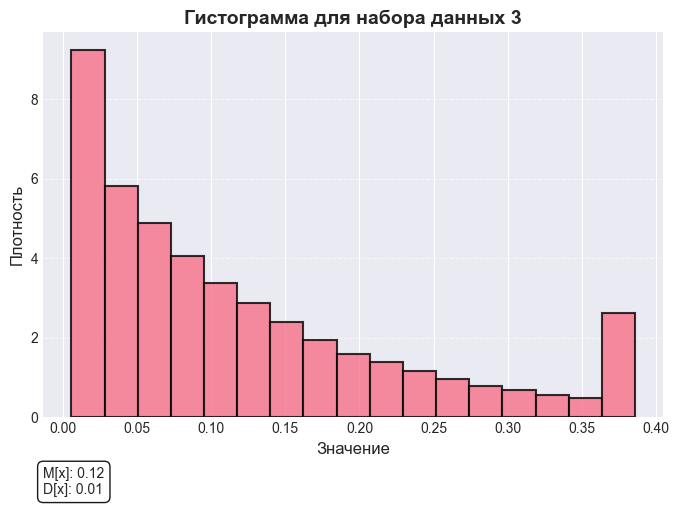

In [36]:
def clean_winsorize(data: np.ndarray, lower_percentile: float = 5, upper_percentile: float = 95):
    """
    Заменяет выбросы на граничные значения с помощью винзоризации.
    :param data: Массив данных.
    :param lower_percentile: Нижний процентиль (по умолчанию 5).
    :param upper_percentile: Верхний процентиль (по умолчанию 95).
    :return: Очищенные данные.
    """
    lower_bound = np.percentile(data, lower_percentile)
    upper_bound = np.percentile(data, upper_percentile)

    clean_data = [min(max(x, lower_bound), upper_bound) for x in data]
    
    return clean_data

clean_data = []
for i, dataset in enumerate(datasets):
    clean_data.append(clean_winsorize(dataset))

draw_gistograms(clean_data)

### Использование медианы и медианного абсолютного отклонения (MAD)

### Использует медиану и MAD для определения выбросов.

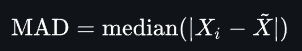
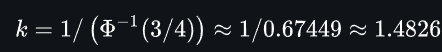

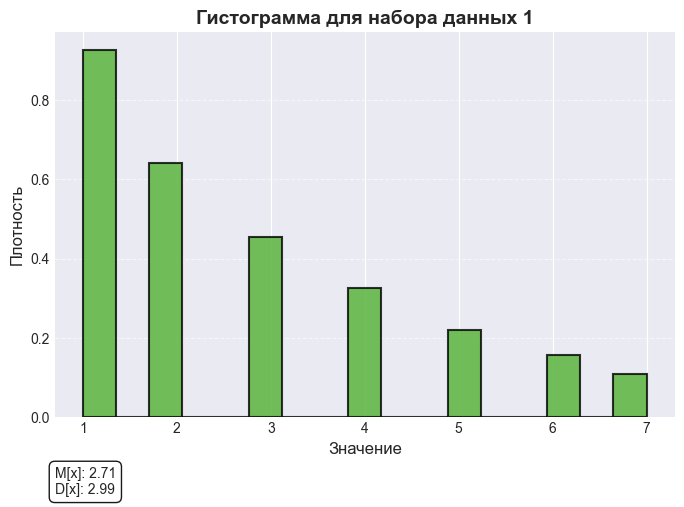

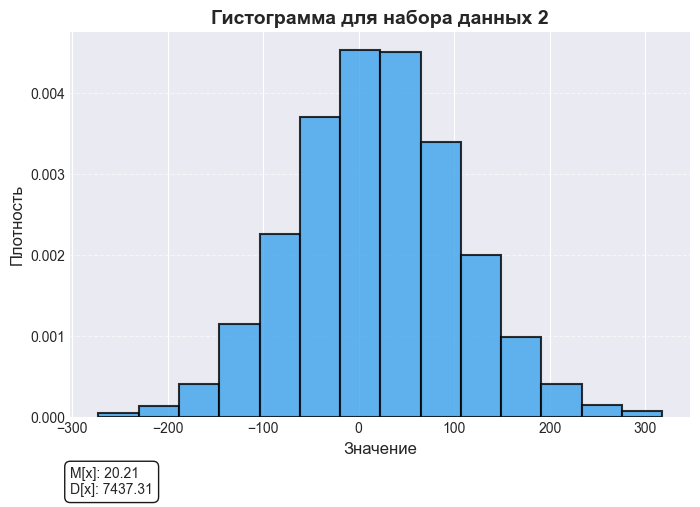

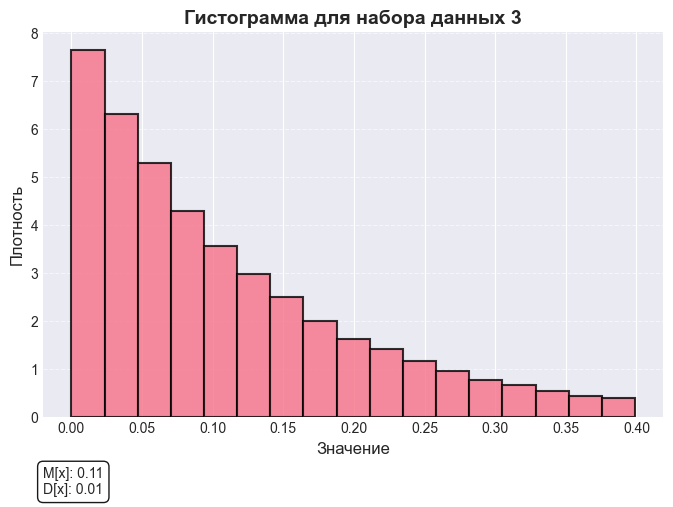

In [37]:
def clean_mad(data: np.ndarray, threshold: float = 3.5):
    """
    Обнаруживает выбросы с помощью медианы и MAD.
    :param data: Массив данных.
    :param threshold: Порог для MAD (по умолчанию 3).
    :return: Очищенные данные.
    """
    median = np.median(data)
    abs_deviations = np.abs(data - median)
    mad = np.median(abs_deviations)
    mad_norm = mad * 1.4826

    clean_data = data[np.abs((data - median) / mad_norm) < threshold]

    return clean_data

clean_data = []
for i, dataset in enumerate(datasets):
    clean_data.append(clean_mad(dataset))

draw_gistograms(clean_data)

#### Таким образом, был выбран метод "Использование медианы и медианного абсолютного отклонения (MAD)". Он будет использоваться для обработки данных.

### 4. Построение гистограмм

#### Используем библиотеку matplotlib для построения гистограмм с нормировкой 100%.

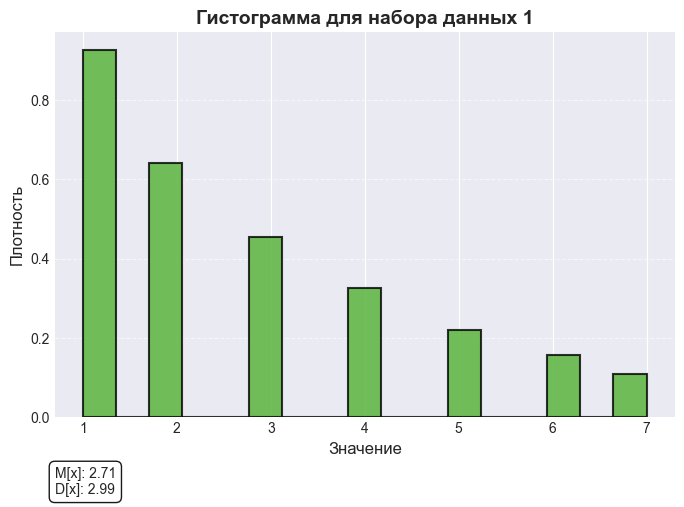

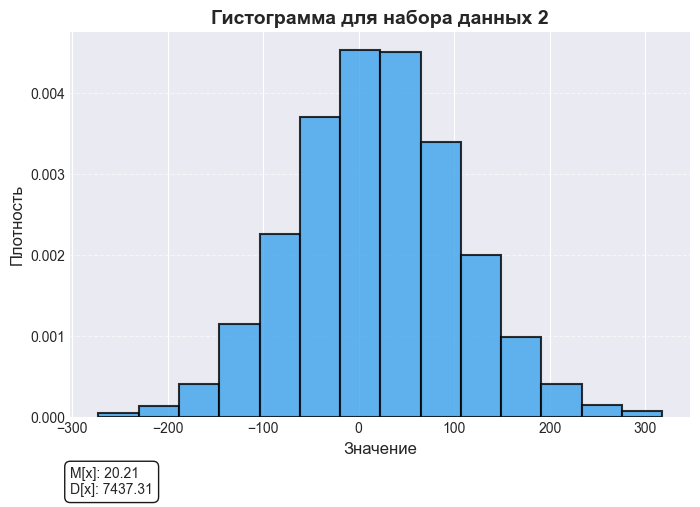

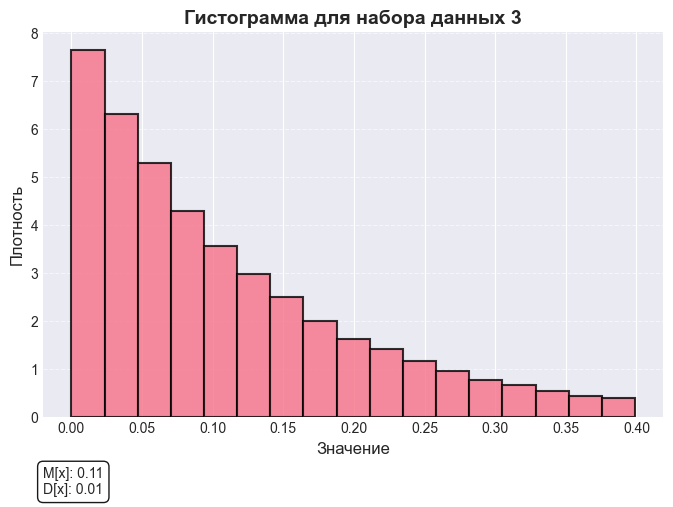

In [38]:
for i, dataset in enumerate(datasets):
    datasets[i] = clean_mad(dataset)

draw_gistograms(datasets)

### 5. Реализация теоретических распределений

#### Реализация функций плотности теоретических распределений.

#### Геометрическое распределение - 
####  распределение дискретной случайной величины X, принимающей целые неотрицательные значения. 
#### Пусть происходит серия независимых испытаний, в каждом из которых событие может появится с одной и той же вероятностью p. Тогда случайная величина X - количество испытаний до первого появления события, имеет геометрическое распределение вероятностей.

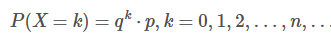
#### Математическое ожидание и дисперсия
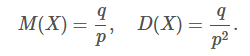

In [39]:
def geometric_distribution(data):
    mean = calculate_mean(data)
    p = 1 / mean

    if p > 1 or p < 0:
        raise ValueError("Не является геометрическим распределением")
    
    y = []
    for num in data:
        y.append(p * ((1 - p) ** (num - 1)))
    
    return data, y


#### Биномиальное распределение

#### Распределение количества «успехов» в последовательности из n независимых случайных экспериментов, таких, что вероятность «успеха» в каждом из них постоянна и равна p

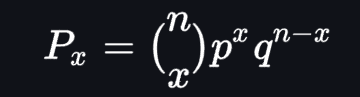
#### где x - количество появлений конкретного результата при n попытках,
#### 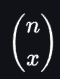 - число комбинаций

#### Математическое ожидание - 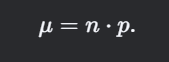
#### Дисперсия - 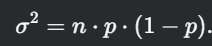

In [40]:
def binomial_distribution(data):
    """
    Вычисляет вероятности для биномиального распределения.
    :param data: Данные.
    :return: Кортеж (x, y), где x — количество успехов, y — вероятности.
    """
    mean = calculate_mean(data)
    p = mean / len(data)

    if p > 1 or p < 0:
        raise ValueError("Не является биномиальным распределением") 
    
    max_val = round(max(data))

    # Генерация значений x (количество успехов)
    x = [i for i in range(max_val + 1)]

    if len(x) <= 1:
        raise ValueError("Не является биномиальным распределением")

    # Вычисление вероятностей y
    y = [comb(max_val, k) * (p ** k) * ((1 - p) ** (max_val - k)) for k in x]
    
    return x, y

#### Распределение Пуассона

#### Если количество испытаний n достаточно велико, а вероятность p появления события A в отдельно взятом испытании весьма мала (0,05-0,1 и меньше), то вероятность того, что в данной серии испытаний событие A появится ровно k раз, можно приближенно вычислить по формуле Пуассона:

#### 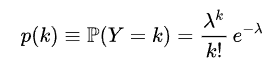, где k - количество событий,  - математическое ожидание
#### Математическое ожидание и дисперсия - 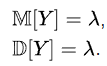 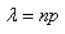

In [41]:
def poisson_distribution(data):
    mean = calculate_mean(data)
    variance = calculate_variance(data)

    if abs(mean - variance) > 1:
        raise ValueError("Не является распределением Пуассона")

    n = len(data)
    p = mean / n

    lambd = n * p
    koeff = math.exp(-lambd)
    max_val = round(max(data))

    x = [i for i in range(0, max_val + 1)]

    if len(x) <= 1:
        raise ValueError("Не является распределением Пуассона")

    y = [koeff]
    for i in range(1, max_val + 1):
        y.append(y[-1] / i * lambd) # Рекуррентная формула
    
    return x, y 

#### Равномерное распределение
#### Есть некоторый конечный промежуток - [a, b]. Если случайная величина X обладает постоянной плотностью распределения вероятностей на данном отрезке и нулевой плотностью вне него, то говорят, что она распределена равномерно.

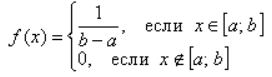
#### Математическое ожидание - 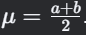
#### Дисперсия - 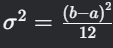
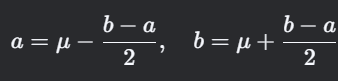

In [42]:
def uniform_distribution(data):
    mean = calculate_mean(data)
    variance = calculate_variance(data)

    # Вычисление ширины интервала (b - a)
    b_minus_a = (variance * 12) ** 0.5

    a = mean - b_minus_a / 2
    b = mean + b_minus_a / 2

    if a >= b:
        raise ValueError("Не является равномерным распределением (a >= b)")
    
    # Вычисление плотностей
    y = [1 / (b - a) if a <= num <= b else 0 for num in data]

    return data, y

#### Нормальное распределение

#### 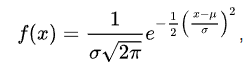, где параметр 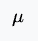 - математическое ожидание, медиана и мода распределения. 
####  - среднеквадратическое отклонение,  - дисперсия распределения.

In [43]:
def normal_distribution(data):
    mean = calculate_mean(data)
    variance = calculate_variance(data)
    sigma = math.sqrt(variance)

    coeff = 1 / (sigma * math.sqrt(2 * math.pi))
    y = []

    for num in data:
        exponenta = math.exp(-0.5 * ((num - mean) / sigma) ** 2)
        y.append(coeff * exponenta)

    return data, y

#### Экспоненциальное распределение

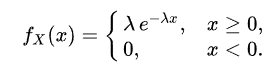
#### Экспоненциальное распределение моделирует время между двумя последовательными свершениями события, а параметр λ описывает среднее число наступлений события в единицу времени.


In [44]:
def exp_distribution(data):
    mean = calculate_mean(data)
    lambda_p = 1 / mean
    y = []

    for num in data:
        if num < 0:
            y.append(0)
        else:
            y.append(lambda_p * (math.exp(-lambda_p * num)))
    
    return data, y

#### Процесс построения распределений для всех наборов данных

Функции распределения
Набор данных 1


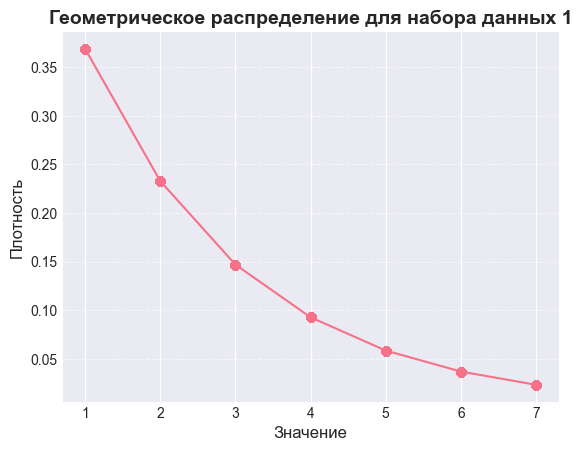

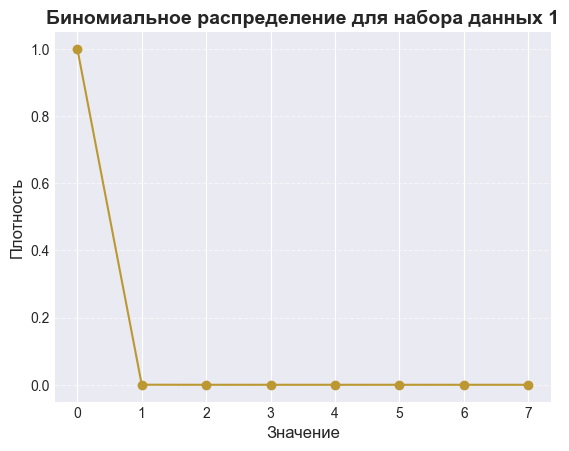

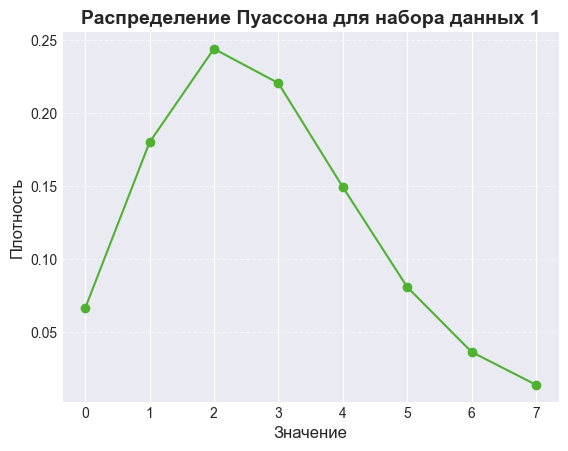

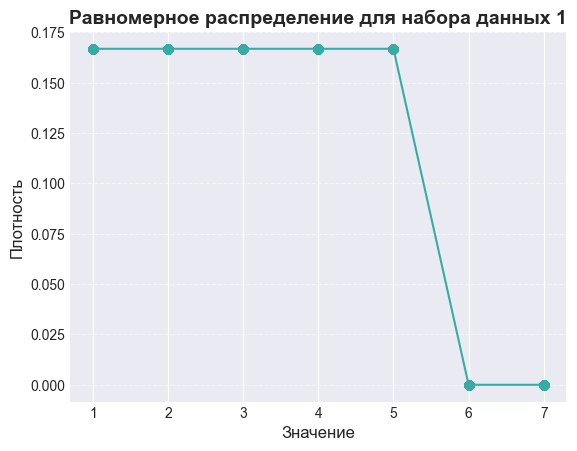

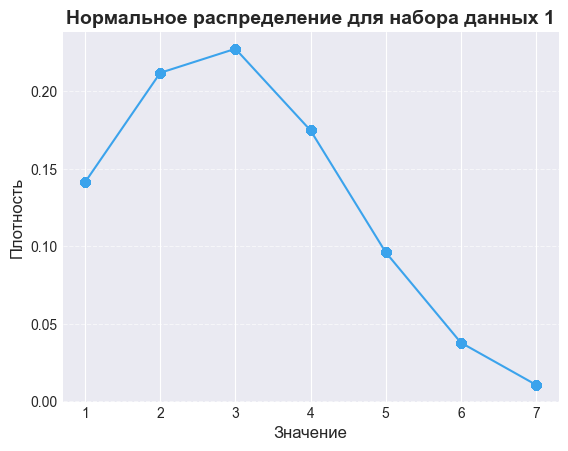

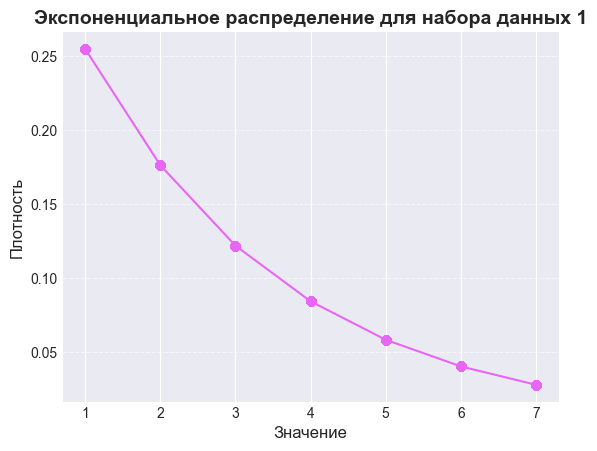

Набор данных 2


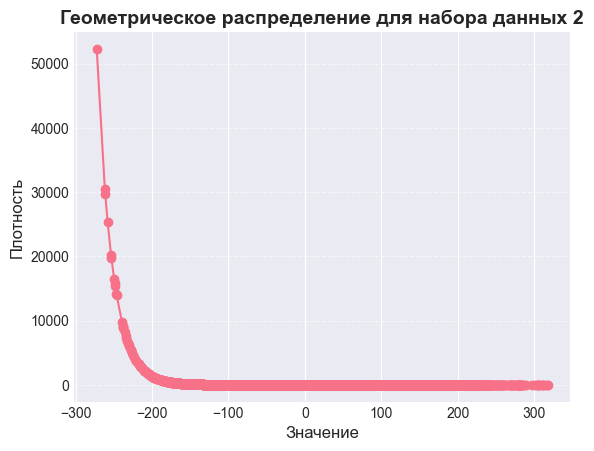

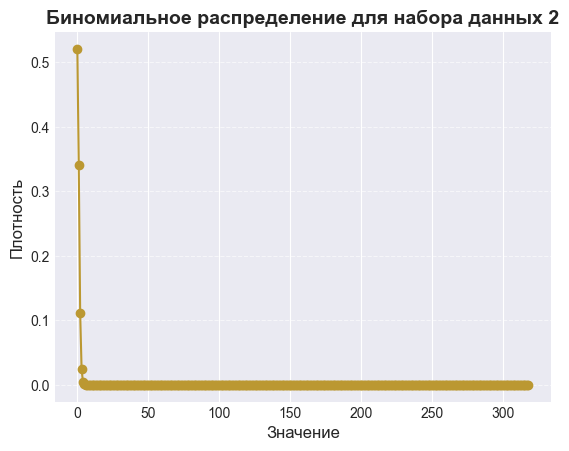

Error: Не является распределением Пуассона


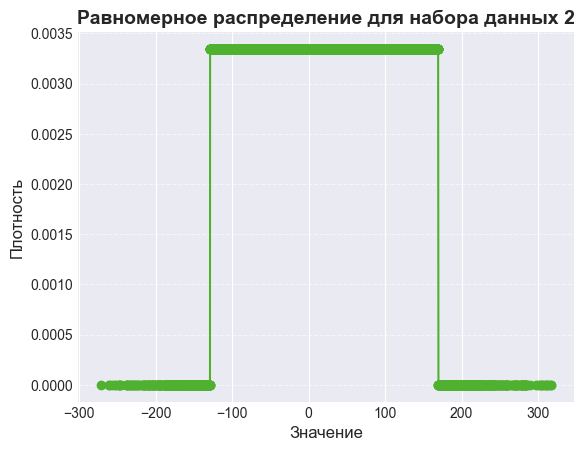

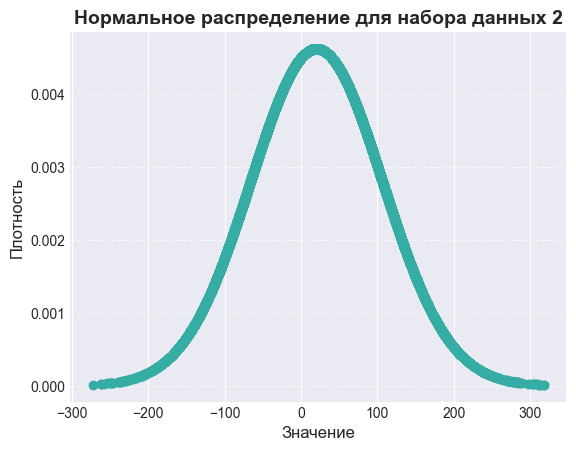

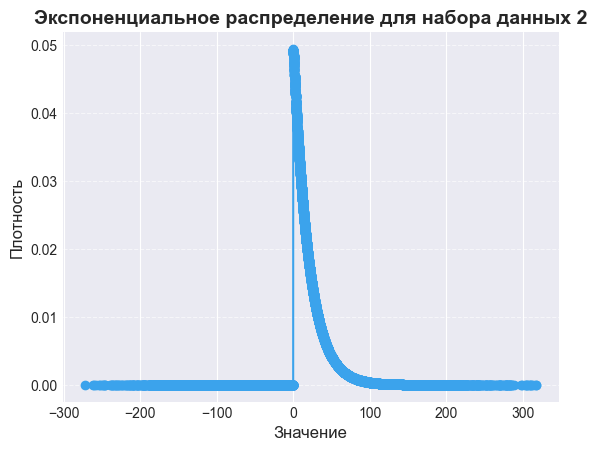

Набор данных 3
Error: Не является геометрическим распределением
Error: Не является биномиальным распределением
Error: Не является распределением Пуассона


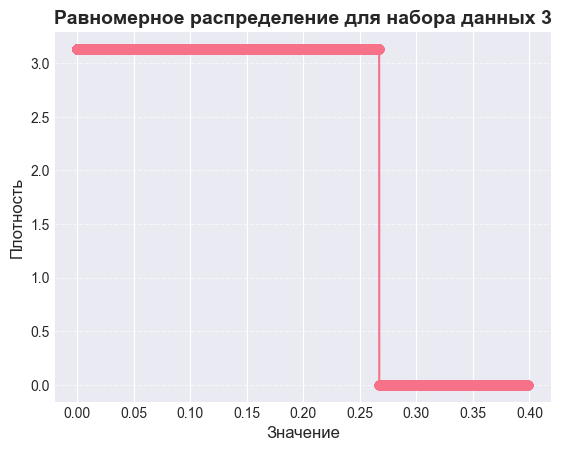

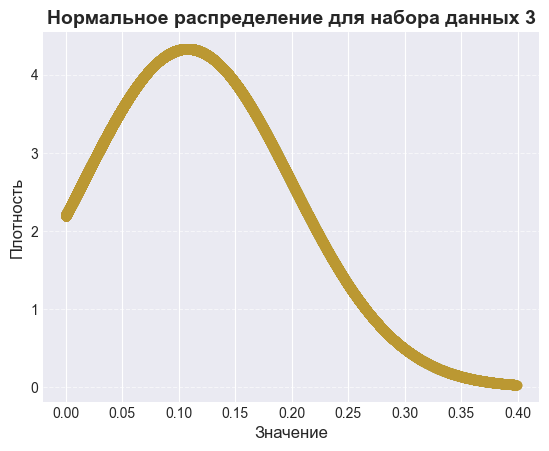

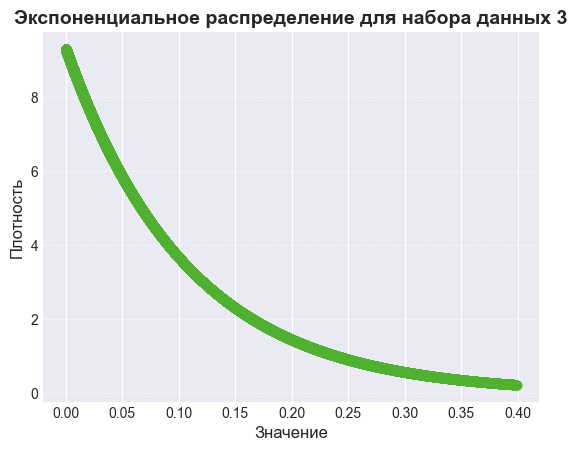

In [45]:
distributions = {
    "Геометрическое распределение": geometric_distribution,
    "Биномиальное распределение": binomial_distribution,
    "Распределение Пуассона": poisson_distribution,
    "Равномерное распределение": uniform_distribution,
    "Нормальное распределение": normal_distribution,
    "Экспоненциальное распределение": exp_distribution
}

plt.style.use("seaborn-v0_8-darkgrid")
colors = sns.color_palette("husl", len(distributions)) 

print("Функции распределения")

for i, dataset in enumerate(datasets, start=1):
    print(f"Набор данных {i}")
    j = 0
    for distrib_name, distrib_func in distributions.items():
        try:
            x_val = np.sort(dataset)
            x_val, y_val = distrib_func(x_val)

            plt.plot(x_val, y_val,
                    marker='o',
                    linestyle='-', 
                    color=colors[j % len(colors)])
            
            plt.title(f"{distrib_name} для набора данных {i}", fontsize=14, fontweight="bold")
            plt.xlabel("Значение", fontsize=12)
            plt.ylabel("Плотность", fontsize=12)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.grid(axis="y", linestyle="--", alpha=0.6)
            plt.show()
        except Exception as e:
            print(f"Error: {e}")
            continue
        j += 1

### 6. Сопоставление и анализ

#### Сравнение построенных теоретических распределений с эмпирическими гистограммами

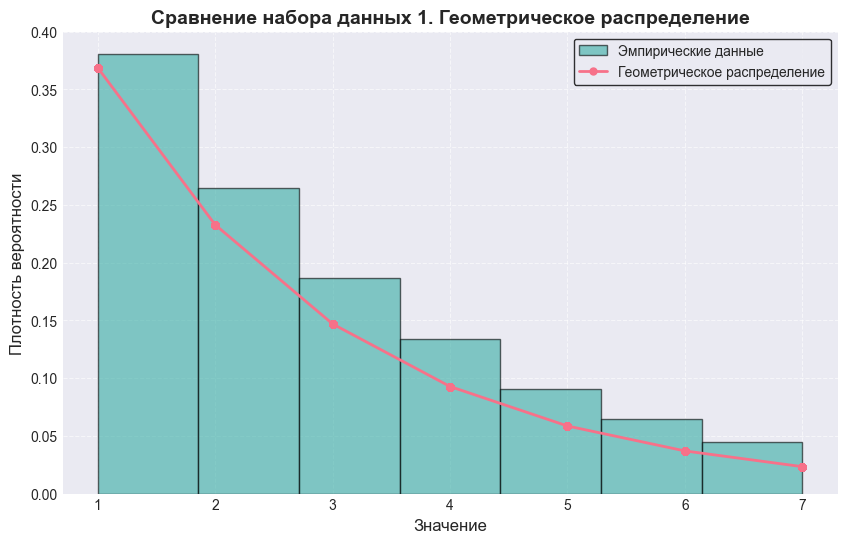

In [46]:
plt.style.use("seaborn-v0_8-darkgrid")
colors = sns.color_palette("husl", 2)

x_val = np.sort(datasets[0])
x_val, y_val = geometric_distribution(x_val)

plt.figure(figsize=(10, 6)) 

# Гистограмма
plt.hist(
    datasets[0], bins=7, density=True, alpha=0.6, 
    color=colors[1], edgecolor="black", label="Эмпирические данные"
)
# График геометрического распределения
plt.plot(
    x_val, y_val, marker='o', markersize=5, linestyle='-', 
    color=colors[0], linewidth=2, label="Геометрическое распределение"
)

plt.title("Сравнение набора данных 1. Геометрическое распределение", fontsize=14, fontweight="bold")
plt.xlabel("Значение", fontsize=12)
plt.ylabel("Плотность вероятности", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="both", linestyle="--", alpha=0.6)
plt.legend(fontsize=10, loc="upper right", frameon=True, edgecolor="black")

plt.show()

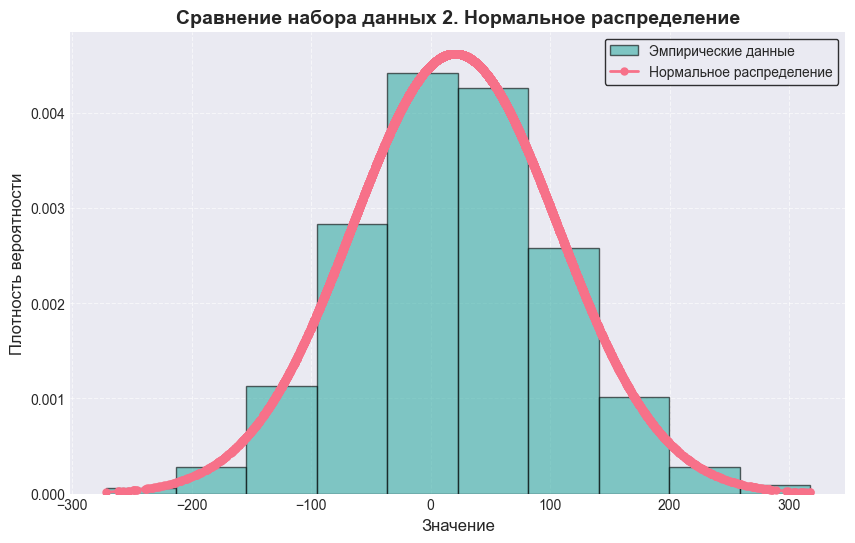

In [47]:
plt.style.use("seaborn-v0_8-darkgrid")
colors = sns.color_palette("husl", 2)

x_val = np.sort(datasets[1])
x_val, y_val = normal_distribution(x_val)

plt.figure(figsize=(10, 6)) 

# Гистограмма
plt.hist(
    datasets[1], bins=10, density=True, alpha=0.6, 
    color=colors[1], edgecolor="black", label="Эмпирические данные"
)
# График биномиального распределения
plt.plot(
    x_val, y_val, marker='o', markersize=5, linestyle='-', 
    color=colors[0], linewidth=2, label="Нормальное распределение"
)

plt.title("Сравнение набора данных 2. Нормальное распределение", fontsize=14, fontweight="bold")
plt.xlabel("Значение", fontsize=12)
plt.ylabel("Плотность вероятности", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="both", linestyle="--", alpha=0.6)
plt.legend(fontsize=10, loc="upper right", frameon=True, edgecolor="black")

plt.show()

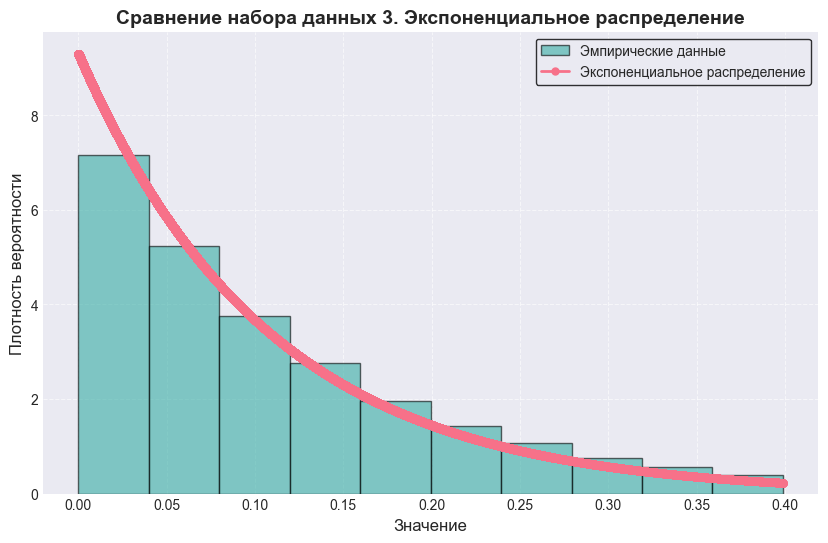

In [48]:
plt.style.use("seaborn-v0_8-darkgrid")
colors = sns.color_palette("husl", 2)

x_val = np.sort(datasets[2])
x_val, y_val = exp_distribution(x_val)

plt.figure(figsize=(10, 6)) 

# Гистограмма
plt.hist(
    datasets[2], bins=10, density=True, alpha=0.6, 
    color=colors[1], edgecolor="black", label="Эмпирические данные"
)
# График эксп распределения
plt.plot(
    x_val, y_val, marker='o', markersize=5, linestyle='-', 
    color=colors[0], linewidth=2, label="Экспоненциальное распределение"
)

plt.title("Сравнение набора данных 3. Экспоненциальное распределение", fontsize=14, fontweight="bold")
plt.xlabel("Значение", fontsize=12)
plt.ylabel("Плотность вероятности", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="both", linestyle="--", alpha=0.6)
plt.legend(fontsize=10, loc="upper right", frameon=True, edgecolor="black")

plt.show()